# Hausarbeit im Seminar Textanalyse WiSe 22/23
## Research Question

Wo sind die Parteien der Hochschulwahlen 2023 in Göttingen im Vergleich zu Bundestagsparteien auf einer Links-Rechts Skala einzuordnen?

## Vorbereitung
Zunächst werden die Parteien definieiert und die Wahlprogramme (soweit vorhanden) eingelesen.

In [2]:
# import modules

import pandas as pd
from nltk.corpus import stopwords
import spacy
from wordscores3 import Wordscores
import matplotlib.pyplot as plt

In [2]:
PARTIES = [
    "ALL_BB",
    "GDF",
    "GHG",
    "JUSO",
    "LHG",
    "LISTE_VOLT",
    "NORDCAMPUS",
    "RCDS"
]

PROGRAMS = {}

for party in PARTIES:
    with open(f"{party}.txt", "r", encoding="utf-8") as f:
        file_content = f.read()
        PROGRAMS[party] = file_content

df = pd.DataFrame(PROGRAMS.items(), columns=["party", "program"])

# MARPOR data for reference texts
BUND_PARTIES = ["CDU", "FDP", "Grüne", "SPD", "AfD", "Linke"]
for party_name in BUND_PARTIES:
    new_df = pd.read_csv(f"{party_name}2021.csv")
    text = " ".join(new_df.text)
    new_row = [party_name, text]
    df.loc[len(df)] = new_row



df

,party,program
0,ALL_BB,"test test test Email sent, waiting for response"
1,GDF,Hochschulpolitik - Nicht mehr und nicht wenige...
2,GHG,"Liebe Studis, \nEs ist wieder so weit, die Hoc..."
3,JUSO,"Liebe Wähler*innen,\nvor euch seht ihr unser W..."
4,LHG,AStA-Beiträge senken\nAllgemeine Studiengebühr...
5,LISTE_VOLT,"Volt & Die LISTE verstehen sich als linkes, pr..."
6,NORDCAMPUS,Mehr interdisziplinäre Zusammenarbeit\nViele S...
7,RCDS,Auslandsstudium\nWer ein Semester im Ausland v...
8,CDU,Das Programm für Stabilität und Erneuerung. GE...
9,FDP,Nie gab es mehr zu tun Wahlprogramm der Freien...


## Data Cleaning
Im nächsten Schritt werden die Wahlprogramme gereinigt. Das Bedeutet, dass einige, für die Analyse unwichtige oder störende, Elemente gelöscht werden.
- Stopwords entfernen
- Lemmatisieren
- Kleinschreibung und entfernen von Tokens unter 3 Zeichen länge.

In [3]:

# stopwords definieren
custom_stopwords = ["test"]
stopwords_used = stopwords.words("german") + custom_stopwords

# lemmatization setup
nlp = spacy.load('de_core_news_sm')


for i, prog in df.program.items():
    print(f"Current: {i+1}/{len(df.program)}...")
    # lemma
    nlp_doc = nlp(prog)
    lemma_list = [x.lemma_ for x in nlp_doc]

    # remove stopwords and lower
    no_stopwords = [word.lower() for word in lemma_list if word.lower() not in stopwords_used]

    # remove short tokens
    min_len = 3
    new_list = [word for word in no_stopwords if len(word) >= min_len]


    # save to df
    df.program[i] = new_list


df.program

Current: 1/14...
Current: 2/14...
Current: 3/14...
Current: 4/14...
Current: 5/14...
Current: 6/14...
Current: 7/14...
Current: 8/14...
Current: 9/14...
Current: 10/14...
Current: 11/14...
Current: 12/14...
Current: 13/14...
Current: 14/14...


0                [email, senen, waiting, for, response]
1     [hochschulpolitik, mehr, weniger, hochschulpol...
2     [liebe, studi, weit, hochschulwahle, stehen, 1...
3     [lieb, wähler*innen, sehen, wahlprogramm, hoch...
4     [asta-beitrag, senken, allgemein, studiengebüh...
5     [volt, liste, verstehen, linkes, progressiv, q...
6     [mehr, interdisziplinär, zusammenarbeit, viele...
7     [auslandsstudium, wer, semester, ausland, verb...
8     [programm, stabilität, erneuerung, gemeinsam, ...
9     [nie, geben, mehr, tun, wahlprogramm, frei, de...
10    [deutschland, drin, bundestagswahlprogramm, 20...
11    [respekt, zukunft, zukunftsprogramm, spd, wofü...
12    [deutschland, normal, programm, alternative, f...
13    [zeit, handeln, sozial, sicherheit, frieden, k...
Name: program, dtype: object

## Wordscores berechnen
Basierend auf [Arbeit von Thiago Marzagao](https://thiagomarzagao.com/2013/06/10/wordscores-in-python/) und angepasst für python 3

In [21]:
def create_word_frequency_matrix(index: int) -> pd.DataFrame:
    absolute_freq = pd.Series(df.program[index]).value_counts()
    relative_freq = pd.Series(df.program[index]).value_counts(normalize=True)
    word_freq_df = pd.DataFrame({
        "abs_freq": absolute_freq,
        "rel_freq": relative_freq
    })

    return(word_freq_df)

for i in range(len(df)):
    create_word_frequency_matrix(i).to_csv(f"inputdata/{df.party[i]}.csv", header=False)



## Referenzwerte für RILE Scores
Als Referenzwerte für die RILE scores werden die von [Franzman und Kaiser (2016)](https://journals.sagepub.com/doi/10.1177/1354068806061336) entwickelten und auf Manifesto Project (MARPOR) beruhenden Zahlen hinzugezogen. Dabei gibt es sowohl eine ökonomische als auch eine soziale Dimension, auf welcher Parteipositionen eingeordnet werden können.

In [22]:
# Franzmann / Kaiser 
#TODO check Party codes

RILE_SCORES = {
    "GRÜNE": (41113, 2.22, 2.95), # (party code, LR_economic, LR_social) 
    "LINKE": (41223, 0.7, 2.67),
    "SPD": (41320, 1.5, 4.53),
    "FDP": (41420, 5.99, 3.52),
    "CDU": (41521, 5.8, 6.37),
    "AFD": (41953, 9.06, 8.15)
}

A_r_econ = pd.DataFrame({'LINKE': RILE_SCORES["LINKE"][1],
                   'AFD': RILE_SCORES["AFD"][1],
                   "Linke": RILE_SCORES["LINKE"][1],
                   "SPD": RILE_SCORES["SPD"][1],
                   "FDP": RILE_SCORES["FDP"][1],
                   "CDU": RILE_SCORES["CDU"][1],
                   "Grüne": RILE_SCORES["GRÜNE"][1]},
                   index = ['score'])

W = Wordscores(A_r=A_r_econ)

results_econ = W.run()[1:]
print(f"{results_econ=}")

A_r_econ = pd.DataFrame({'LINKE': RILE_SCORES["LINKE"][2],
                   'AFD': RILE_SCORES["AFD"][2],
                   "Linke": RILE_SCORES["LINKE"][2],
                   "SPD": RILE_SCORES["SPD"][2],
                   "FDP": RILE_SCORES["FDP"][2],
                   "CDU": RILE_SCORES["CDU"][2],
                   "Grüne": RILE_SCORES["GRÜNE"][2]},
                   index = ['score'])

W = Wordscores(A_r=A_r_econ)

results_social = W.run()[1:]
print(f"{results_social=}")

c:\Users\User\Desktop\Uni\WiSe 22-23\Empirische Demokratieforschung\Seminar_Methoden_der_Analyse_politischer_Texte_und_ihre_Anwendung\python_code\hausarbeit\wordscores3.py:56: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.P_wr = self.F_wr.iloc[:, 1:].div(self.F_wr.sum(axis = 1), axis = 0)


results_econ=               score
GDF         1.509650
GHG         2.090320
JUSO        4.044552
LHG         3.147488
LISTE_VOLT  4.555025
NORDCAMPUS  3.449712
RCDS        5.090974


c:\Users\User\Desktop\Uni\WiSe 22-23\Empirische Demokratieforschung\Seminar_Methoden_der_Analyse_politischer_Texte_und_ihre_Anwendung\python_code\hausarbeit\wordscores3.py:56: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.P_wr = self.F_wr.iloc[:, 1:].div(self.F_wr.sum(axis = 1), axis = 0)


results_social=               score
GDF         2.760032
GHG         2.925285
JUSO        4.110934
LHG         3.090792
LISTE_VOLT  4.323755
NORDCAMPUS  3.711444
RCDS        4.065189


In [25]:
# Education Expansion (per506) / Environment Protection (per501) 

RILE_SCORES = {
    "GRÜNE": (41113, 2.987, 7.975),
    "LINKE": (41223, 3.047, 4.714),
    "SPD": (41320, 3.21, 3.448),
    "FDP": (41420, 4.253, 4.298),
    "CDU": (41521, 1.802, 4.252),
    "AFD": (41953, 1.842, 2.478)
}

A_r_econ = pd.DataFrame({'LINKE': RILE_SCORES["LINKE"][1],
                   'AFD': RILE_SCORES["AFD"][1],
                   "Linke": RILE_SCORES["LINKE"][1],
                   "SPD": RILE_SCORES["SPD"][1],
                   "FDP": RILE_SCORES["FDP"][1],
                   "CDU": RILE_SCORES["CDU"][1],
                   "Grüne": RILE_SCORES["GRÜNE"][1]},
                   index = ['score'])

W = Wordscores(A_r=A_r_econ)

results_econ = W.run()[1:]
print(f"{results_econ=}")

A_r_econ = pd.DataFrame({'LINKE': RILE_SCORES["LINKE"][2],
                   'AFD': RILE_SCORES["AFD"][2],
                   "Linke": RILE_SCORES["LINKE"][2],
                   "SPD": RILE_SCORES["SPD"][2],
                   "FDP": RILE_SCORES["FDP"][2],
                   "CDU": RILE_SCORES["CDU"][2],
                   "Grüne": RILE_SCORES["GRÜNE"][2]},
                   index = ['score'])

W = Wordscores(A_r=A_r_econ)

results_social = W.run()[1:]
print(f"{results_social=}")

c:\Users\User\Desktop\Uni\WiSe 22-23\Empirische Demokratieforschung\Seminar_Methoden_der_Analyse_politischer_Texte_und_ihre_Anwendung\python_code\hausarbeit\wordscores3.py:56: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.P_wr = self.F_wr.iloc[:, 1:].div(self.F_wr.sum(axis = 1), axis = 0)


results_econ=               score
GDF         2.013947
GHG         2.091884
JUSO        2.388508
LHG         2.078713
LISTE_VOLT  2.418154
NORDCAMPUS  2.314171
RCDS        2.302133


c:\Users\User\Desktop\Uni\WiSe 22-23\Empirische Demokratieforschung\Seminar_Methoden_der_Analyse_politischer_Texte_und_ihre_Anwendung\python_code\hausarbeit\wordscores3.py:56: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.P_wr = self.F_wr.iloc[:, 1:].div(self.F_wr.sum(axis = 1), axis = 0)


results_social=               score
GDF         3.488217
GHG         3.645367
JUSO        4.134346
LHG         3.260499
LISTE_VOLT  4.279673
NORDCAMPUS  3.976842
RCDS        3.799758


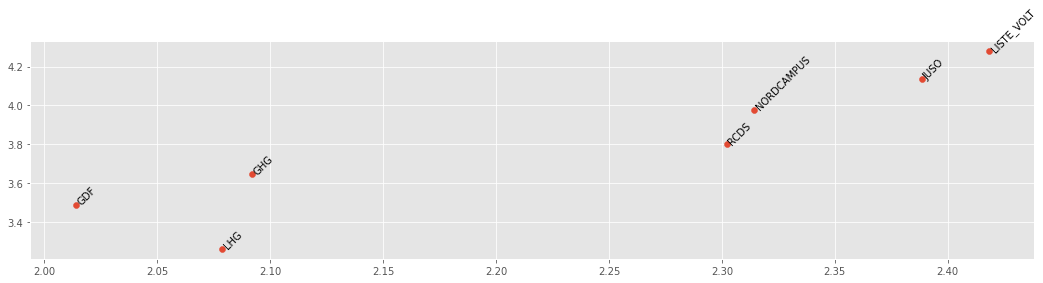

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 4)

x = results_econ.score
y = results_social.score
ax.scatter(x, y)
txt = results_econ.index
for i, txt in enumerate(txt):
    ax.annotate(txt, (x[i], y[i]), rotation=45)

# ax.axis("off")
plt.show()

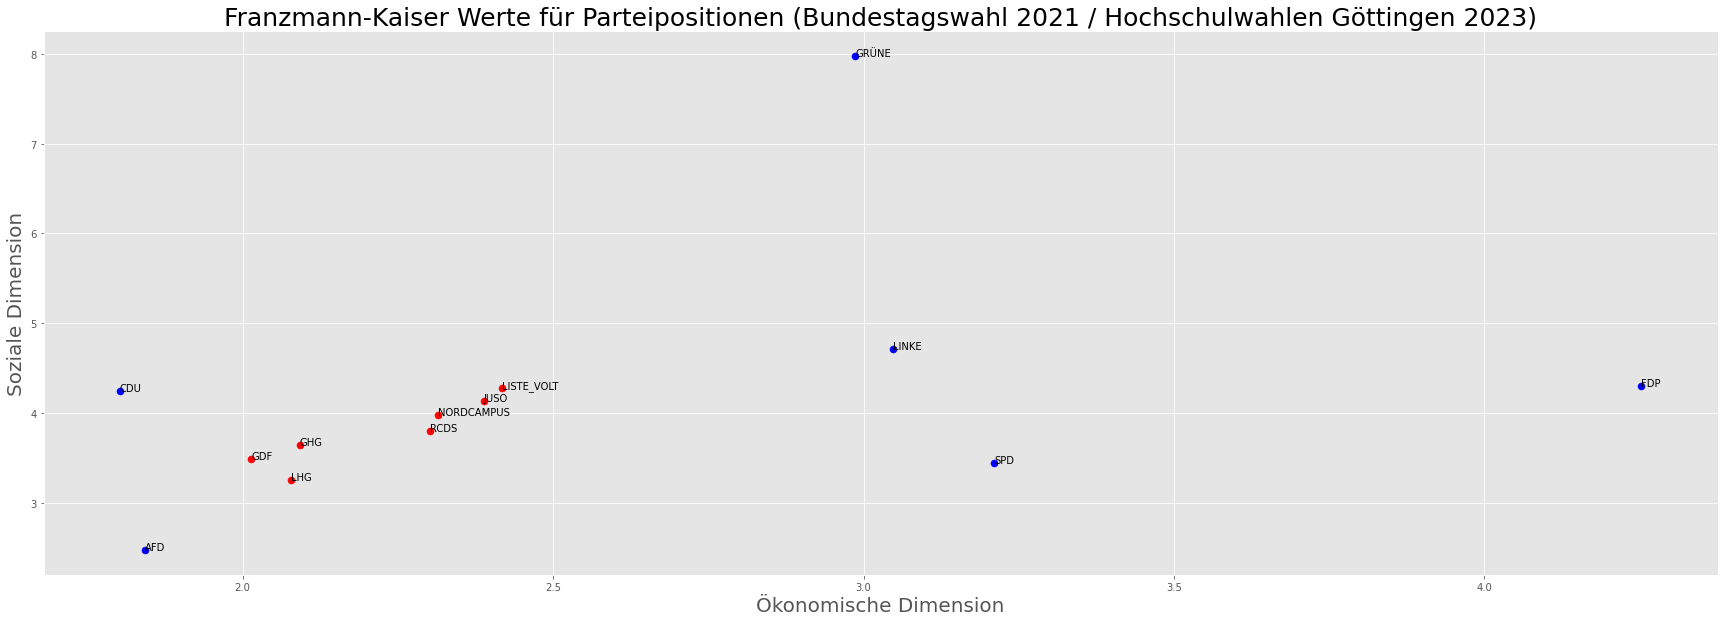

In [28]:
fig, ax = plt.subplots()
fig.set_size_inches(30, 10)

x = results_econ.score
y = results_social.score
ax.scatter(x, y, color="red", s=50)
txt = results_econ.index
for i, txt in enumerate(txt):
    ax.annotate(txt, (x[i], y[i]), rotation=0)

# add bundestag parties
p_names = RILE_SCORES.keys()
x_bund = [RILE_SCORES[p_name][1] for p_name in p_names]
y_bund = [RILE_SCORES[p_name][2] for p_name in p_names]
ax.scatter(x_bund, y_bund, color="blue", s=50)


for i, p_name in enumerate(p_names):
    ax.annotate(p_name, (x_bund[i], y_bund[i]), rotation=0)

label_font = {"size": 20}

plt.title("Franzmann-Kaiser Werte für Parteipositionen (Bundestagswahl 2021 / Hochschulwahlen Göttingen 2023)", fontdict={"size": 25})
plt.xlabel("Ökonomische Dimension", fontdict=label_font)
plt.ylabel("Soziale Dimension", fontdict=label_font)
# ax.axis("off")

plt.style.use("ggplot")
plt.show()

## Wahlprogramme der Bundestagsparteien reduzieren
Die Parteien der Hochschulwahlen fokussieren sich Hauptsächlich auf den universitären Kontext. Daher ist es vielleicht sinnvoll die Wahlprogramme auf die Teile zu reduzieren, in welchen über Bildung gesprochen wird. 

Das wird dadurch erreicht, dass nur die Teile der Wahlprogramme als Referenztexte in die Analyse aufgenommen werden, welche in der MARPOR kodierung zu "Domain 5: Welfare and Quality of Life" (per501-per507) gehören. 

Zudem wird die Kategorie "Technology and Infrastructure: Positive" (411) aufgenomemn, da mit dieser viele Aufrufe zur modernisierung und digitalisierung der Lehre kodiert sind.

In [20]:
# Wahlprogramme reduzieren

included_categories = ["501", "502", "503", "504", "505","506", "507", "411"]
# included_categories = [501.0, 502.0, 503.0, 504.0, 505.0, 506.0, 507.0, 411.0]


PARTIES = [
    "ALL_BB",
    "GDF",
    "GHG",
    "JUSO",
    "LHG",
    "LISTE_VOLT",
    "NORDCAMPUS",
    "RCDS"
]

PROGRAMS = {}

for party in PARTIES:
    with open(f"{party}.txt", "r", encoding="utf-8") as f:
        file_content = f.read()
        PROGRAMS[party] = file_content

df = pd.DataFrame(PROGRAMS.items(), columns=["party", "program"])

# MARPOR data for reference texts
BUND_PARTIES = ["CDU", "FDP", "Grüne", "SPD", "AfD", "Linke"]
for party_name in BUND_PARTIES:
    new_df = pd.read_csv(f"{party_name}2021.csv")
    reduced_df = new_df[new_df["cmp_code"].isin(included_categories)]     # df gets limited
    text = " ".join(reduced_df.text)
    new_row = [party_name, text]
    df.loc[len(df)] = new_row



# stopwords definieren
custom_stopwords = ["test"]
stopwords_used = stopwords.words("german") + custom_stopwords

# lemmatization setup
nlp = spacy.load('de_core_news_sm')


for i, prog in df.program.items():
    print(f"Current: {i+1}/{len(df.program)}...")
    # lemma
    nlp_doc = nlp(prog)
    lemma_list = [x.lemma_ for x in nlp_doc]

    # remove stopwords and lower
    no_stopwords = [word.lower() for word in lemma_list if word.lower() not in stopwords_used]

    # remove short tokens
    min_len = 3
    new_list = [word for word in no_stopwords if len(word) >= min_len]


    # save to df
    df.program[i] = new_list


df.program

Current: 1/14...
Current: 2/14...
Current: 3/14...
Current: 4/14...
Current: 5/14...
Current: 6/14...
Current: 7/14...
Current: 8/14...
Current: 9/14...
Current: 10/14...
Current: 11/14...
Current: 12/14...
Current: 13/14...
Current: 14/14...


0                [email, senen, waiting, for, response]
1     [hochschulpolitik, mehr, weniger, hochschulpol...
2     [liebe, studi, weit, hochschulwahle, stehen, 1...
3     [lieb, wähler*innen, sehen, wahlprogramm, hoch...
4     [asta-beitrag, senken, allgemein, studiengebüh...
5     [volt, liste, verstehen, linkes, progressiv, q...
6     [mehr, interdisziplinär, zusammenarbeit, viele...
7     [auslandsstudium, wer, semester, ausland, verb...
8     [20er, jahr, modernisierungsjahrzehnt, land, d...
9     [staat, gesundheitssystem, digitalisieren, ges...
10    [global, krise, zeit, zuallererst, klimakrise,...
11    [überwinden, wachsend, ungleichheit, nehmen, w...
12    [prinzip, gleichheit, gesetz, artikel, grundge...
13    [coronakrise, ungerechtigkeit, kapitalismus, d...
Name: program, dtype: object

## Weitere Ideen:
- Textskalierungsverfahren für explorativere analyse
- Wordfish für latente Dimension, die mehr zu tatsächlichen Positionen der Uni-Parteien aussagt?

# Word2vec
Word2vec ist eine weitere Methode, um einen Textcorpus als Vektor darzustellen. Dazu werden die libraries Natural Language Toolkit (``nltk``) und ``gensim`` verwendet.